In [1]:
# data manipulation
import pandas as pd
import numpy as np
import re

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
train_df = pd.read_csv('/content/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df[train_df['keyword'].isna() != 1].head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Dependendo do modelo talvez seja necessário fazer encoding de keyword e location.

In [6]:
for i in range(5):
    print(train_df['text'].iloc[i])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


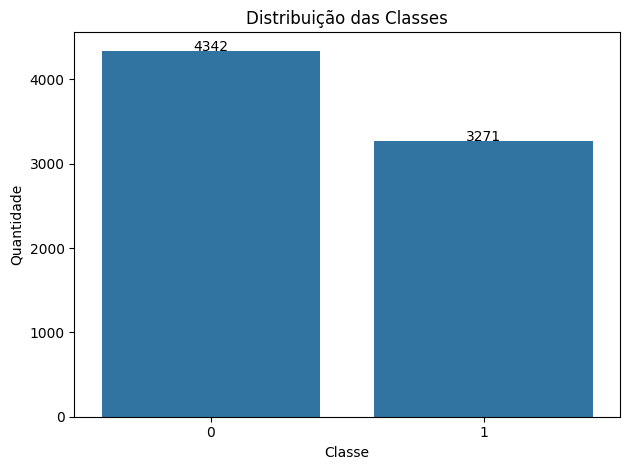

In [7]:
ax = sns.countplot(x='target', data=train_df)

for p in ax.patches:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width() / 2,
            y=height + 0.1,
            s=f'{int(height)}',
            ha='center')

plt.title('Distribuição das Classes')
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.tight_layout()

42% dos dados estão na classe 1 e 58% na classe 0. Se o recall estiver ruim, pode ser interessante testar técnicas de balanceamento.

In [8]:
train_df["num_palavras"] = train_df["text"].apply(lambda x: len(x.split()))
train_df["num_caracteres"] = train_df["text"].apply(lambda x: len(x))

In [9]:
print(train_df["num_palavras"].describe())
print()
print(train_df["num_caracteres"].describe())

count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: num_palavras, dtype: float64

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: num_caracteres, dtype: float64


Text(0.5, 1.0, 'Histograma do numero de caracteres por tweet')

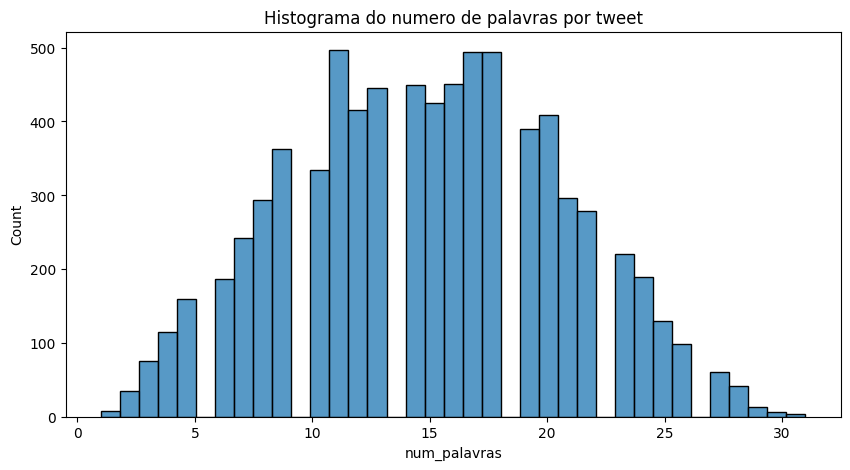

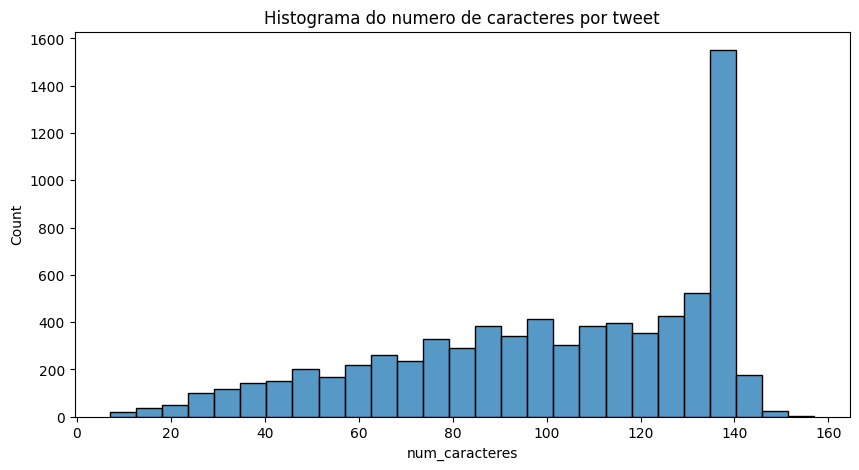

In [20]:
plt.figure(figsize=(10, 5))
sns.histplot(train_df["num_palavras"])
plt.title("Histograma do numero de palavras por tweet")

plt.figure(figsize=(10, 5))
sns.histplot(train_df["num_caracteres"])
plt.title("Histograma do numero de caracteres por tweet")

Text(0.5, 1.0, 'Histograma do numero de caracteres por tweet')

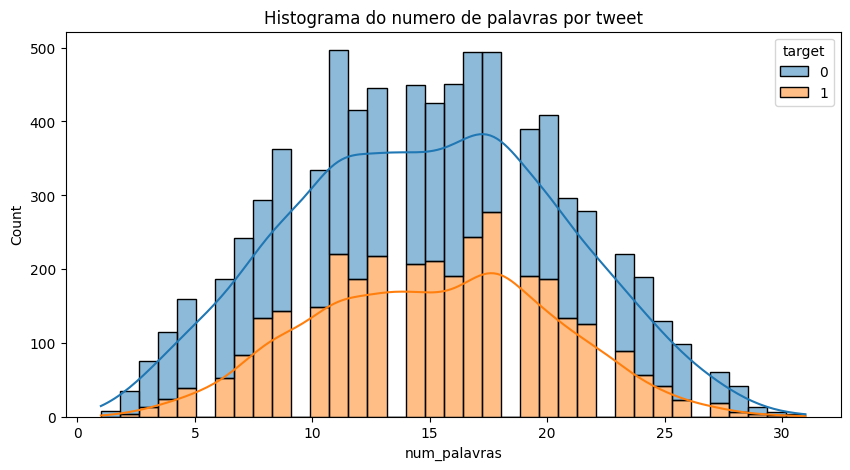

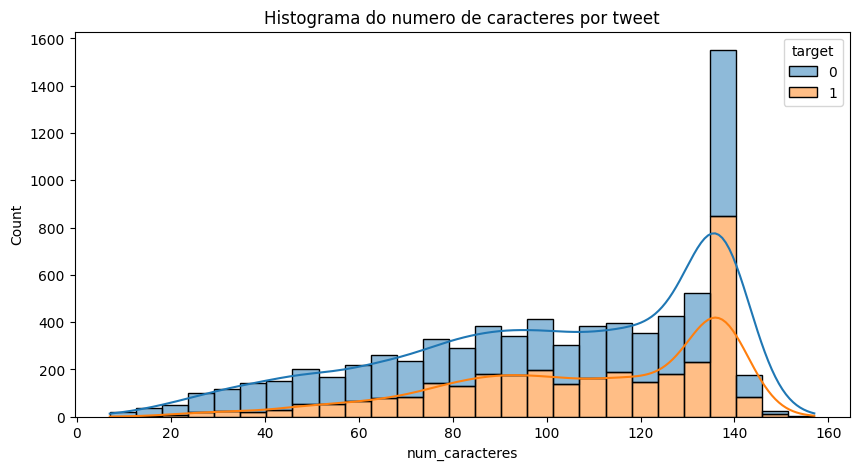

In [22]:
plt.figure(figsize=(10, 5))
sns.histplot(data=train_df, x="num_palavras", hue="target", multiple="stack", kde=True)
plt.title("Histograma do numero de palavras por tweet")

plt.figure(figsize=(10, 5))
sns.histplot(data=train_df, x="num_caracteres", hue="target", multiple="stack", kde=True)
plt.title("Histograma do numero de caracteres por tweet")

### Palavras
Quantidade de palavras principalmente entre 10 e 20, poucos tweets com menos de 5 ou mais de 25.

Como o valor máximo é 31, podemos usar max_length=32 se utilizar um modelo com tamanho fixo.

### Caracteres
Média de 101, com muitos tweets em 140 (limite de tweets do antigo twitter), muitos tweets foram escritos no limite da plataforma.

- Seria interessante remover/transformar tweets com URLs, @menções e hashtags?

In [11]:
def tem_url(texto):
    return bool(re.search(r"http[s]?://\S+", texto))

def tem_mencao(texto):
    return bool(re.search(r"@\w+", texto))

def tem_hashtag(texto):
    return bool(re.search(r"#\w+", texto))

train_df["tem_url"] = train_df["text"].apply(tem_url)
train_df["tem_mencao"] = train_df["text"].apply(tem_mencao)
train_df["tem_hashtag"] = train_df["text"].apply(tem_hashtag)

In [12]:
def print_head_rows(df):
    for i in range(5):
        print(df['text'].iloc[i])

In [13]:
print("Tweets com URL:")
print_head_rows(train_df[train_df["tem_url"]])

print("\nTweets com menção:")
print_head_rows(train_df[train_df["tem_mencao"]])

print("\nTweets com hashtag:")
print_head_rows(train_df[train_df["tem_hashtag"]])

Tweets com URL:
@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw
#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi
On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N
INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA

Tweets com menção:
@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
@PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season.
SOOOO PUMPED FOR ABLAZE ???? @southridgelife
Noches El-Bestia '@Alexis_Sanchez: happy to see my teammates and training hard ?? goodnight gunners.?????? http://t.co/uc4j4jHvGR'
@Navista7 Steve these fires out here are something else! California is a tinderbox - and this clown was setting my 'hood ablaze @News24680

Tweets com hashtag:
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
13,000 people receive #wildfires evacua

In [14]:
print("\nProporção com URL:", train_df["tem_url"].mean())
print("Proporção com menção:", train_df["tem_mencao"].mean())
print("Proporção com hashtag:", train_df["tem_hashtag"].mean())


Proporção com URL: 0.5216077761723368
Proporção com menção: 0.2638907132536451
Proporção com hashtag: 0.22895047944305794


Ideias:
- Interessante substituir os links por tokens especiais, como URLTOKEN, para diminuir ruído.
- Talvez criar coluna onde há mais de 1 link, pois talvez existe uma boa chance de ser spam, bot, ou algo assim.
- Subistituir @someone por @MENTION, para reduzir ruído (contas aleatórias)
- Talvez remover o "#" das hashtags

In [15]:
print("Quantidade de valores ausentes")
print(train_df.isnull().sum())

print("\nProporção de valores ausentes")
print(train_df.isnull().mean())

Quantidade de valores ausentes
id                   0
keyword             61
location          2533
text                 0
target               0
num_palavras         0
num_caracteres       0
tem_url              0
tem_mencao           0
tem_hashtag          0
dtype: int64

Proporção de valores ausentes
id                0.000000
keyword           0.008013
location          0.332720
text              0.000000
target            0.000000
num_palavras      0.000000
num_caracteres    0.000000
tem_url           0.000000
tem_mencao        0.000000
tem_hashtag       0.000000
dtype: float64


- Para keyword, talvez seja interessante trocar os valores ausentes por algo como "no_keyword", além disso, adicionar uma coluna extra booleana, com 1 para onde há valores ausentes.
- Em location tem muitos valores ausentes, talvez seja bom criar uma nova coluna dizendo se o valor está presente ou não (como em keywords). É possível fazer geocodificação, clusterização textual, ou RBF features.

In [16]:
duplicatas = train_df.duplicated(subset=['text'])
print(f"Numero de dados duplicados: {duplicatas.sum()}\n")

print_head_rows(train_df[duplicatas])

Numero de dados duplicados: 110

Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw
320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/zEVakJaPcz
320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/THyzOMVWU0 | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/83jOO0xk29
Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on Wednesday began examining t...
To fight bioterrorism sir.


Interessante remover dados duplicados.

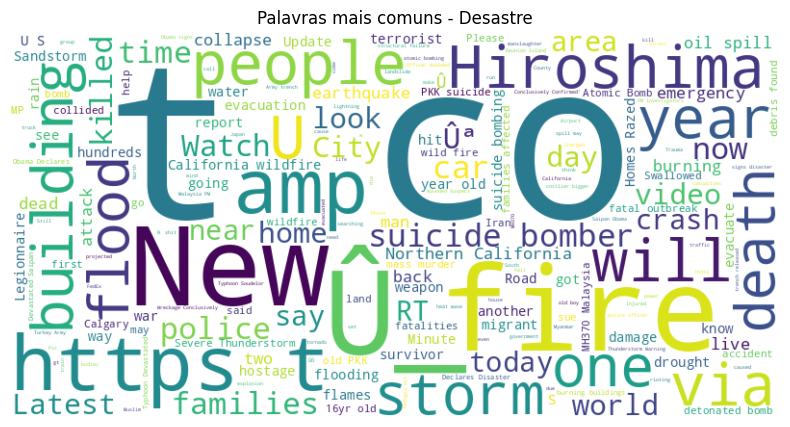

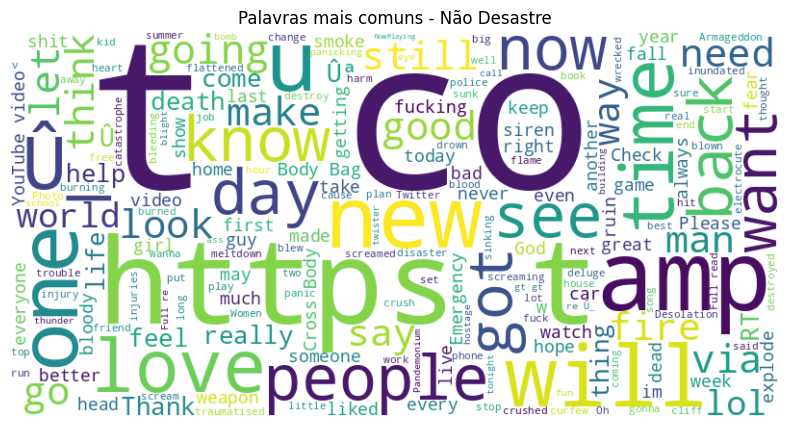

In [17]:
texto_target_1 = " ".join(train_df[train_df["target"]==1]["text"])
texto_target_0 = " ".join(train_df[train_df["target"]==0]["text"])

# Classe 1
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_target_1)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Palavras mais comuns - Desastre")
plt.show()

# Classe 0
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_target_0)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Palavras mais comuns - Não Desastre")
plt.show()

In [18]:
# correlação entre keyword e target
train_df.groupby("keyword")["target"].mean().sort_values(ascending=False).head(10)

,target
keyword,
derailment,1.000000
debris,1.000000
wreckage,1.000000
outbreak,0.975000
typhoon,0.973684
oil%20spill,0.973684
suicide%20bombing,0.969697
suicide%20bomber,0.967742
bombing,0.931034


# preprocessing

In [23]:
# Interessante substituir os links por tokens especiais, como URLTOKEN, para diminuir ruído.
# Talvez criar coluna onde há mais de 1 link, pois talvez existe uma boa chance de ser spam, bot, ou algo assim.
# Subistituir @someone por @MENTION, para reduzir ruído (contas aleatórias)
# Talvez remover o "#" das hashtags

In [25]:
train_df.head()

,id,keyword,location,text,target,num_palavras,num_caracteres,tem_url,tem_mencao,tem_hashtag
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,False,False,True
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,False,False,False
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,133,False,False,False
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,False,False,True
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,False,False,True


In [26]:
import re

In [27]:

def substituir_url(texto):
    url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+|www\.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+|ftp[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+') # chat gpt god
    return url_pattern.sub(r'URLTOKEN', texto)

def substituir_mencao(texto):
    mention_pattern = re.compile(r'@[\w_]+')
    return mention_pattern.sub(r'@MENTION', texto)

In [28]:
train_df['text_tratado'] = train_df['text'].apply(substituir_url)
train_df['text_tratado'] = train_df['text_tratado'].apply(substituir_mencao)

In [29]:
train_df['text_tratado']

,text_tratado
0,Our Deeds are the Reason of this #earthquake M...
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...
...,...
7608,Two giant cranes holding a bridge collapse int...
7609,@MENTION @MENTION The out of control wild fire...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. URL...
7611,Police investigating after an e-bike collided ...


In [ ]:
train_df.to_csv('./tratado.csv', index=False)

# v0

## nessa v0 seria algo meio direto, pegar texto e classificar, mas pensei em combinar o texto com as outras features (keyword, location, num_palavras e num_caracteres, acho que daria para fazer um ensemble ou um stacked da vida)

In [ ]:
!pip install --upgrade transformers datasets numpy

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv('/content/tratado.csv')

In [3]:
train_df.head()

,id,keyword,location,text,target,num_palavras,num_caracteres,tem_url,tem_mencao,tem_hashtag,text_tratado
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,False,False,True,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,False,False,False,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,133,False,False,False,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,False,False,True,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,False,False,True,Just got sent this photo from Ruby #Alaska as ...


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
import torch

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
train_df = train_df.rename(columns={'target': 'label'})

In [7]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text_tratado'].tolist(),
    train_df['label'].tolist(),
    test_size=0.2,
    random_state=0,
    stratify=train_df['label']
)

train_dataset_dict = {"text": train_texts, "label": train_labels}
val_dataset_dict = {"text": val_texts, "label": val_labels}

train_dataset = Dataset.from_dict(train_dataset_dict)
val_dataset = Dataset.from_dict(val_dataset_dict)

dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

In [8]:
MODEL_NAME = "neuralmind/bert-base-portuguese-cased"

In [9]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

num_labels = 2
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [10]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [11]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

In [20]:
training_args = TrainingArguments(
    output_dir="/working/results",
    learning_rate=2e-5,
    per_device_train_batch_size=96,
    per_device_eval_batch_size=96,
    num_train_epochs=5,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=5,
    logging_dir='/working/logs',
    report_to=[]
)

In [21]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary' if num_labels == 2 else 'weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets.get("validation"),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics if 'validation' in tokenized_datasets else None
)

<ipython-input-22-863bd3c5b8f7>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [23]:
trainer.train()
print("Treinamento concluído!")

final_model_path = "./model"
trainer.save_model(final_model_path)
tokenizer.save_pretrained(final_model_path)
print(f"Modelo e tokenizador salvos em: {final_model_path}")


print("\nAvaliando no conjunto de validação...")
eval_results = trainer.evaluate()
print(f"Resultados da Avaliação: {eval_results}")


Step,Training Loss
64,0.372100
128,0.319600
192,0.267500
256,0.235000
320,0.207300


Treinamento concluído!
Modelo e tokenizador salvos em: ./model

Avaliando no conjunto de validação...


Resultados da Avaliação: {'eval_loss': 0.5915722250938416, 'eval_accuracy': 0.7944845699277742, 'eval_f1': 0.756420233463035, 'eval_precision': 0.7702060221870047, 'eval_recall': 0.7431192660550459, 'eval_runtime': 10.6002, 'eval_samples_per_second': 143.676, 'eval_steps_per_second': 1.509, 'epoch': 5.0}
